In [1]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt

DIR_TRAIN = "../input/100-bird-species/train/"
DIR_VALID = "../input/100-bird-species/valid/"
DIR_TEST = "../input/100-bird-species/test/"

# Load filenames

Data set of 400 bird species.58388 training images, 2000 test images(5 images per species) and 2000 validation images(5 images per species. This is a very high quality dataset where there is only one bird in each image and the bird typically takes up at least 50% of the pixels in the image. As a result even a moderatly complex model will achieve training and test accuracies in the mid 90% range.

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
In this tutorial we will take a deeper look at how to finetune and feature extract the torchvision models, all of which have been pretrained on the 1000-class Imagenet dataset. This tutorial will give an indepth look at how to work with several modern CNN architectures, and will build an intuition for finetuning any PyTorch model. Since each model architecture is different, there is no boilerplate finetuning code that will work in all scenarios. Rather, the researcher must look at the existing architecture and make custom adjustments for each model.

Must watch!

In [2]:
### Exploring Dataset



classes_train = os.listdir(DIR_TRAIN)
print("Total Classes in Train: ",len(classes_train))

classes_valid = os.listdir(DIR_VALID)
print("Total Classes in Valid: ",len(classes_valid))

classes_test = os.listdir(DIR_TEST)
print("Total Classes in Test: ",len(classes_test))


#Counting total train, valid & test images

train_count = 0
valid_count = 0
test_count = 0
for _class in classes_train:
    train_count += len(os.listdir(DIR_TRAIN + _class))
for _class in classes_valid:
    valid_count += len(os.listdir(DIR_VALID + _class))
for _class in classes_test:
    test_count += len(os.listdir(DIR_TEST + _class))

print("Total train images: ",train_count)
print("Total valid images: ",valid_count)
print("Total test images: ",test_count)

Total Classes in Train:  400
Total Classes in Valid:  400
Total Classes in Test:  400
Total train images:  58388
Total valid images:  2000
Total test images:  2000


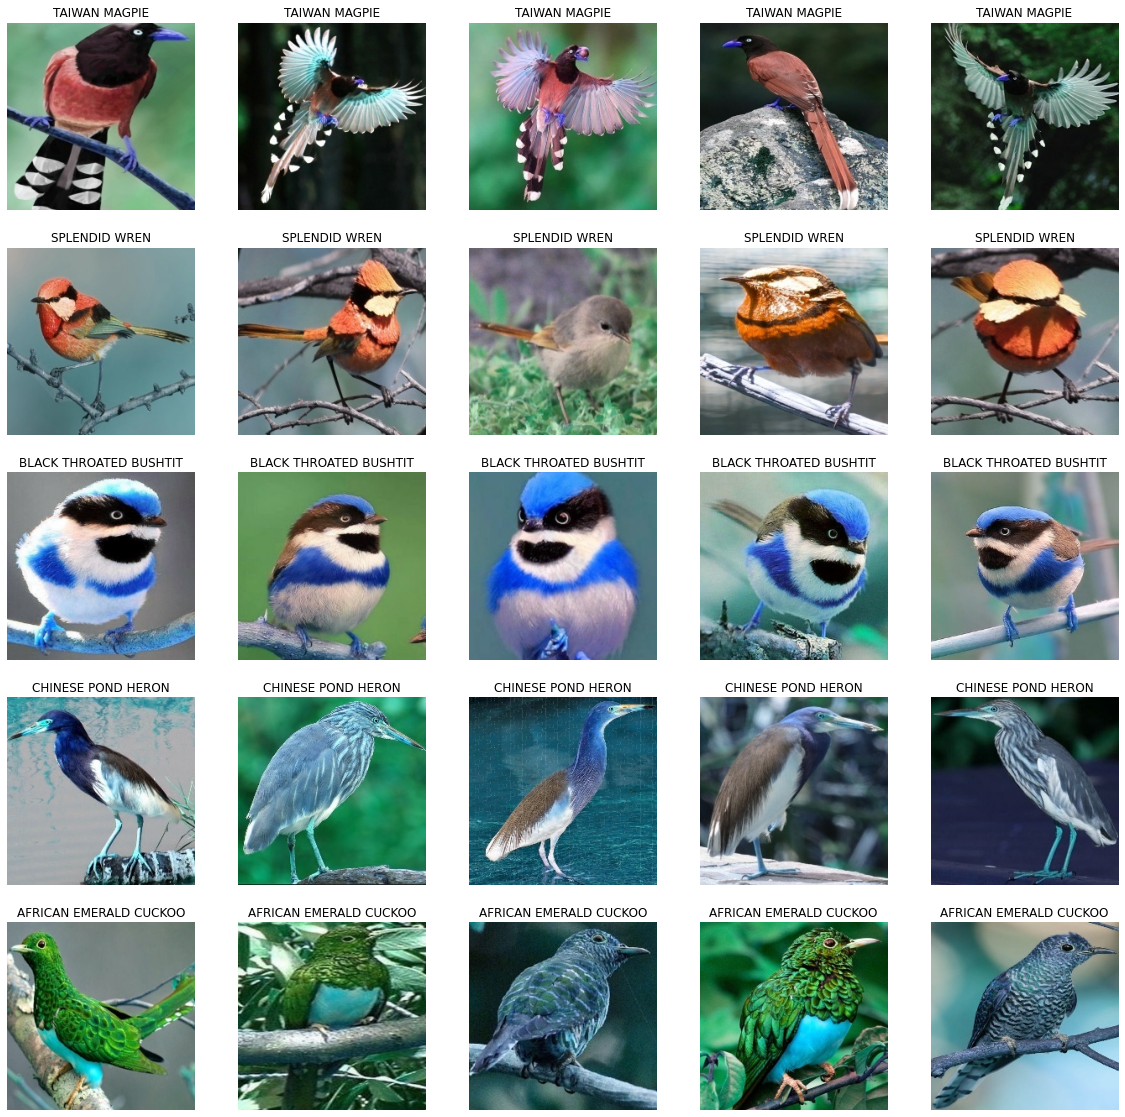

In [3]:

img_list = []
cls_list = []
start_class = 35
num_classes = 5
num_img = 5

for class_ in classes_train[start_class : start_class + num_classes]:
    
    sample_class = class_
    
    sample_imgs = []
    for img in os.listdir(DIR_VALID + sample_class):
        sample_imgs.append(DIR_VALID + sample_class + "/" + img)

    for img_path in sample_imgs:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_list.append(img)
        cls_list.append(sample_class)


plt.figure(figsize=(20,20))
for j in range(num_classes * num_img):
    plt.subplot(5, 5, j+1)
    plt.axis('off')
    plt.imshow(img_list[j])
    plt.title(cls_list[j])
        

In [4]:
print(set(classes_valid) - set(classes_train))
print(set(classes_train) - set(classes_valid))

{'BLACK & YELLOW BROADBILL'}
{'BLACK & YELLOW  BROADBILL'}


In [5]:
### Creating a list of all images : DIR_TRAIN/class_folder/img.jpg - FOR METHOD 2 of data loading
#   A dict for mapping class labels to index

train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes_train:
    #if _class == 'BLACK &  YELLOW BROADBILL': continue
        
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)

for _class in classes_valid:
   # if _class == 'BLACK & YELLOW BROADBILL': continue
        
    for img in os.listdir(DIR_VALID + _class):
        valid_imgs.append(DIR_VALID + _class + "/" + img)
        
for _class in classes_test:
    #if _class == 'BLACK & YELLOW BROADBILL': continue
        
    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

class_to_int = {classes_train[i] : i for i in range(len(classes_train))}
int_to_class = {i : classes_train[i]  for i in range(len(classes_train))}
test_imgs[:10]

['../input/100-bird-species/test/WATTLED CURASSOW/5.jpg',
 '../input/100-bird-species/test/WATTLED CURASSOW/1.jpg',
 '../input/100-bird-species/test/WATTLED CURASSOW/4.jpg',
 '../input/100-bird-species/test/WATTLED CURASSOW/3.jpg',
 '../input/100-bird-species/test/WATTLED CURASSOW/2.jpg',
 '../input/100-bird-species/test/CARMINE BEE-EATER/5.jpg',
 '../input/100-bird-species/test/CARMINE BEE-EATER/1.jpg',
 '../input/100-bird-species/test/CARMINE BEE-EATER/4.jpg',
 '../input/100-bird-species/test/CARMINE BEE-EATER/3.jpg',
 '../input/100-bird-species/test/CARMINE BEE-EATER/2.jpg']

# Loading Classification Dataset

In [6]:
### Loading Classification Dataset - FOR METHOD 2: For multi-class data, by inheriting Dataset class

### VGG16
def get_transform():
    return T.Compose([T.ToTensor()])


class BirdDataset(Dataset):
    
    def __init__(self, imgs_list, class_to_int, transforms = None):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
        image_path = self.imgs_list[index]
        
        #Reading image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        #Retriving class label
        label = image_path.split("/")[-2]
        
        # mistake in data folder
        if label == 'BLACK & YELLOW BROADBILL':
            label = 'BLACK & YELLOW  BROADBILL'
        
        label = self.class_to_int[label]
        
        #Applying transforms on image
        if self.transforms:
            image = self.transforms(image)
        
        return image, label
        
        
        
    def __len__(self):
        return len(self.imgs_list)

In [7]:
from PIL import Image
from torchvision import transforms

### RESNET ## MobilNet

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def get_transform_resnet():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


class BirdDataset_resnet(Dataset):
    
    def __init__(self, imgs_list, class_to_int, transforms = None):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
        image_path = self.imgs_list[index]
        
        #Reading image
        input_image = Image.open(image_path)

        if self.transforms:
            image = self.transforms(input_image)
            
        #image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        #image /= 255.0
        
        #Retriving class label
        label = image_path.split("/")[-2]
        
        # mistake in data folder
        if label == 'BLACK & YELLOW BROADBILL':
            label = 'BLACK & YELLOW  BROADBILL'
        
        label = self.class_to_int[label]
        
        return image, label
        
        
        
    def __len__(self):
        return len(self.imgs_list)

In [8]:
### Loading Classification Dataset

"""
# Method 1: For multi-class data directly from folders using ImageFolder
train_dataset = ImageFolder(root = DIR_TRAIN, transform = T.ToTensor())
valid_dataset = ImageFolder(root = DIR_VALID, transform = T.ToTensor())
test_dataset = ImageFolder(root = DIR_TEST, transform = T.ToTensor())
"""
#  For VGG
# Method 2: Using Dataset Class
#train_dataset = BirdDataset(train_imgs, class_to_int, get_transform())
#valid_dataset = BirdDataset(valid_imgs, class_to_int, get_transform())
#test_dataset = BirdDataset(test_imgs, class_to_int, get_transform())

# For MobilNet
#train_dataset = BirdDataset_for_MobilNetV2(train_imgs, class_to_int, get_transform())
#valid_dataset = BirdDataset_for_MobilNetV2(valid_imgs, class_to_int, get_transform())
#test_dataset = BirdDataset_for_MobilNetV2(test_imgs, class_to_int, get_transform())

#  For RESNET
train_dataset = BirdDataset_resnet(train_imgs, class_to_int, get_transform_resnet())
valid_dataset = BirdDataset_resnet(valid_imgs, class_to_int, get_transform_resnet())
test_dataset = BirdDataset_resnet(test_imgs, class_to_int, get_transform_resnet())


#RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [16, 1, 3, 224, 224]

#Data Loader  -  using Sampler (YT Video)
train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)
test_random_sampler = RandomSampler(test_dataset)

#Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    shuffle=True,
    #sampler = train_random_sampler,
    num_workers = 2,
)

valid_data_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 16,
    shuffle=False,
    #sampler = valid_random_sampler,
    num_workers = 2,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    shuffle=False,
    #sampler = test_random_sampler,
    num_workers = 2,
)

In [9]:
# Visualize one training batch

# First method
#for images, labels in train_data_loader:
#    fig, ax = plt.subplots(figsize = (10, 10))
#    ax.set_xticks([])
#    ax.set_yticks([])
#    ax.imshow(make_grid(images, 4).permute(1,2,0))
#    break

def print_sample(train_data_loader, row=4, col=4):
    (img,label) = next(iter(train_data_loader))
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j].permute(1,2,0))
        plt.title(int_to_class[int(label[j].numpy())])

#print_sample(train_data_loader)

# Define model

1) VVG16 
2) RESNET18
3) MobilNETV2

# vgg16

In [10]:
# vgg16
# INPUT: [224x224x3]        memory:  224*224*3=150K   weights: 0
# CONV3-64: [224x224x64]  memory:  224*224*64=3.2M   weights: (3*3*3)*64 = 1,728
# CONV3-64: [224x224x64]  memory:  224*224*64=3.2M   weights: (3*3*64)*64 = 36,864
# POOL2: [112x112x64]  memory:  112*112*64=800K   weights: 0
# CONV3-128: [112x112x128]  memory:  112*112*128=1.6M   weights: (3*3*64)*128 = 73,728
# CONV3-128: [112x112x128]  memory:  112*112*128=1.6M   weights: (3*3*128)*128 = 147,456
# POOL2: [56x56x128]  memory:  56*56*128=400K   weights: 0
# CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*128)*256 = 294,912
# CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*256)*256 = 589,824
# CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*256)*256 = 589,824
# POOL2: [28x28x256]  memory:  28*28*256=200K   weights: 0
# CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*256)*512 = 1,179,648
# CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*512)*512 = 2,359,296
# CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*512)*512 = 2,359,296
# POOL2: [14x14x512]  memory:  14*14*512=100K   weights: 0
# CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
# CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
# CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
# POOL2: [7x7x512]  memory:  7*7*512=25K  weights: 0
# FC: [1x1x4096]  memory:  4096  weights: 7*7*512*4096 = 102,760,448
# FC: [1x1x4096]  memory:  4096  weights: 4096*4096 = 16,777,216
# FC: [1x1x1000]  memory:  1000 weights: 4096*1000 = 4,096,000

# TOTAL memory: 24M * 4 bytes ~= 93MB / image (only forward! ~*2 for bwd)
# TOTAL params: 138M parameters

In [11]:
#def __init__(self):
#        super(DANNet, self).__init__()
#        model = models.vgg16(pretrained=True)  #False
#
#        self.features = model.features
#        for param in self.features.parameters(): #NOTE: prune:True  // finetune:False
#            param.requires_grad = True
#
#        self.classifier = nn.Sequential(
#            nn.Dropout(),
#            nn.Linear(25088, 4096),
#            nn.ReLU(inplace=True),
#            nn.Dropout(),
#            nn.Linear(4096, 4096),
#            nn.ReLU(inplace=True),
#        )
#        self.cls_fc = nn.Linear(4096, 31) 

In [12]:
#model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
#model.classifier = nn.Sequential(
#    nn.Linear(25088, 4096, bias = True),
#    nn.ReLU(inplace = True),
#    nn.Dropout(0.4),
#    nn.Linear(4096, 2048, bias = True),
#    nn.ReLU(inplace = True),
#    nn.Dropout(0.4),
#    nn.Linear(2048, 400)
#)


In [13]:
#from model import MobileNetV2

# RESNET18

In [14]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
num_classes = 400
model.fc = nn.Linear(512, num_classes)

In [17]:
### Get device

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # 0.0001
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 5

In [18]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [19]:
for images, labels in train_data_loader:
        
    images = images.to(device)
    labels = labels.to(device)
        
    #Reset Grads
    optimizer.zero_grad()
        
        #Forward ->
    preds = model(images)
                  
    break
                  
pr = preds.cpu()

calc_accuracy(labels.cpu(), preds.cpu())

0.0

In [20]:
pred = preds.cpu()
true = labels.cpu()
print(pred)
pred = F.softmax(pred, dim = 1)
print(pred)
print(pred.max())
true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
print(true)
acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
acc = float((100 * acc.sum()) / len(acc))
acc

tensor([[ 0.4506,  0.8634, -0.1011,  ...,  0.6304, -1.0686, -0.4872],
        [ 0.1718,  0.5730, -1.0144,  ...,  0.5023, -1.1029, -0.6690],
        [ 1.0241,  0.0051,  0.6309,  ..., -0.4007, -0.8004, -0.6578],
        ...,
        [ 0.1619,  0.4065, -0.2706,  ...,  0.4867, -0.6794, -0.7753],
        [ 0.1761,  1.4179,  0.1995,  ..., -0.1537, -2.0411, -1.6447],
        [ 0.7020,  0.3273, -0.4308,  ...,  0.4523, -1.3480, -0.7640]],
       grad_fn=<ToCopyBackward0>)
tensor([[0.0029, 0.0044, 0.0017,  ..., 0.0035, 0.0006, 0.0011],
        [0.0022, 0.0033, 0.0007,  ..., 0.0031, 0.0006, 0.0010],
        [0.0050, 0.0018, 0.0034,  ..., 0.0012, 0.0008, 0.0009],
        ...,
        [0.0024, 0.0031, 0.0016,  ..., 0.0034, 0.0011, 0.0010],
        [0.0021, 0.0074, 0.0022,  ..., 0.0015, 0.0002, 0.0003],
        [0.0038, 0.0026, 0.0012,  ..., 0.0030, 0.0005, 0.0009]],
       grad_fn=<SoftmaxBackward0>)
tensor(0.0294, grad_fn=<MaxBackward1>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,

0.0

In [21]:
### Training Code

for epoch in range(epochs):
    
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    for images, labels in train_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss & Backward, Update Weights (Step)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        #Append loss & acc
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)
        
        if _iter % 500 == 0:
            print("> Iteration {} < ".format(_iter))
            print("Iter Loss = {}".format(round(loss_value, 4)))
            print("Iter Accuracy = {} % \n".format(acc))
        
        _iter += 1
    
    #Validation
    for images, labels in valid_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward ->
        with torch.no_grad():
            preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss
        loss = criterion(preds, labels)
        
        #Append loss & acc
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)
    
    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    #Print Epoch Statistics
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("* Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("* Train Accuracy = {} %".format(train_epoch_accuracy))
    print("* Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("* Val Accuracy = {} % \n".format(val_epoch_accuracy))
    
    

> Iteration 500 < 
Iter Loss = 5.9768
Iter Accuracy = 0.0 % 

> Iteration 1000 < 
Iter Loss = 4.9324
Iter Accuracy = 0.0 % 

> Iteration 1500 < 
Iter Loss = 4.2742
Iter Accuracy = 6.25 % 

> Iteration 2000 < 
Iter Loss = 1.8111
Iter Accuracy = 56.25 % 

> Iteration 2500 < 
Iter Loss = 1.2928
Iter Accuracy = 62.5 % 

> Iteration 3000 < 
Iter Loss = 1.1417
Iter Accuracy = 68.75 % 

> Iteration 3500 < 
Iter Loss = 1.8545
Iter Accuracy = 75.0 % 

** Epoch 0 ** - Epoch Time 319
* Train Loss = 3.2211
* Train Accuracy = 36.40239726027397 %
* Val Loss = 0.6588
* Val Accuracy = 82.4 % 

> Iteration 500 < 
Iter Loss = 0.834
Iter Accuracy = 75.0 % 

> Iteration 1000 < 
Iter Loss = 0.633
Iter Accuracy = 81.25 % 

> Iteration 1500 < 
Iter Loss = 0.5682
Iter Accuracy = 81.25 % 

> Iteration 2000 < 
Iter Loss = 0.574
Iter Accuracy = 75.0 % 

> Iteration 2500 < 
Iter Loss = 0.3278
Iter Accuracy = 87.5 % 

> Iteration 3000 < 
Iter Loss = 1.0511
Iter Accuracy = 75.0 % 

> Iteration 3500 < 
Iter Loss = 0

In [22]:
def calc_accuracy_2(true,pred):
    pred = F.softmax(pred, dim = 1)
    #print(pred)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3]
[ 0  0  0  0  0  1  1  1  1  1  2  2  2 18  2  3]


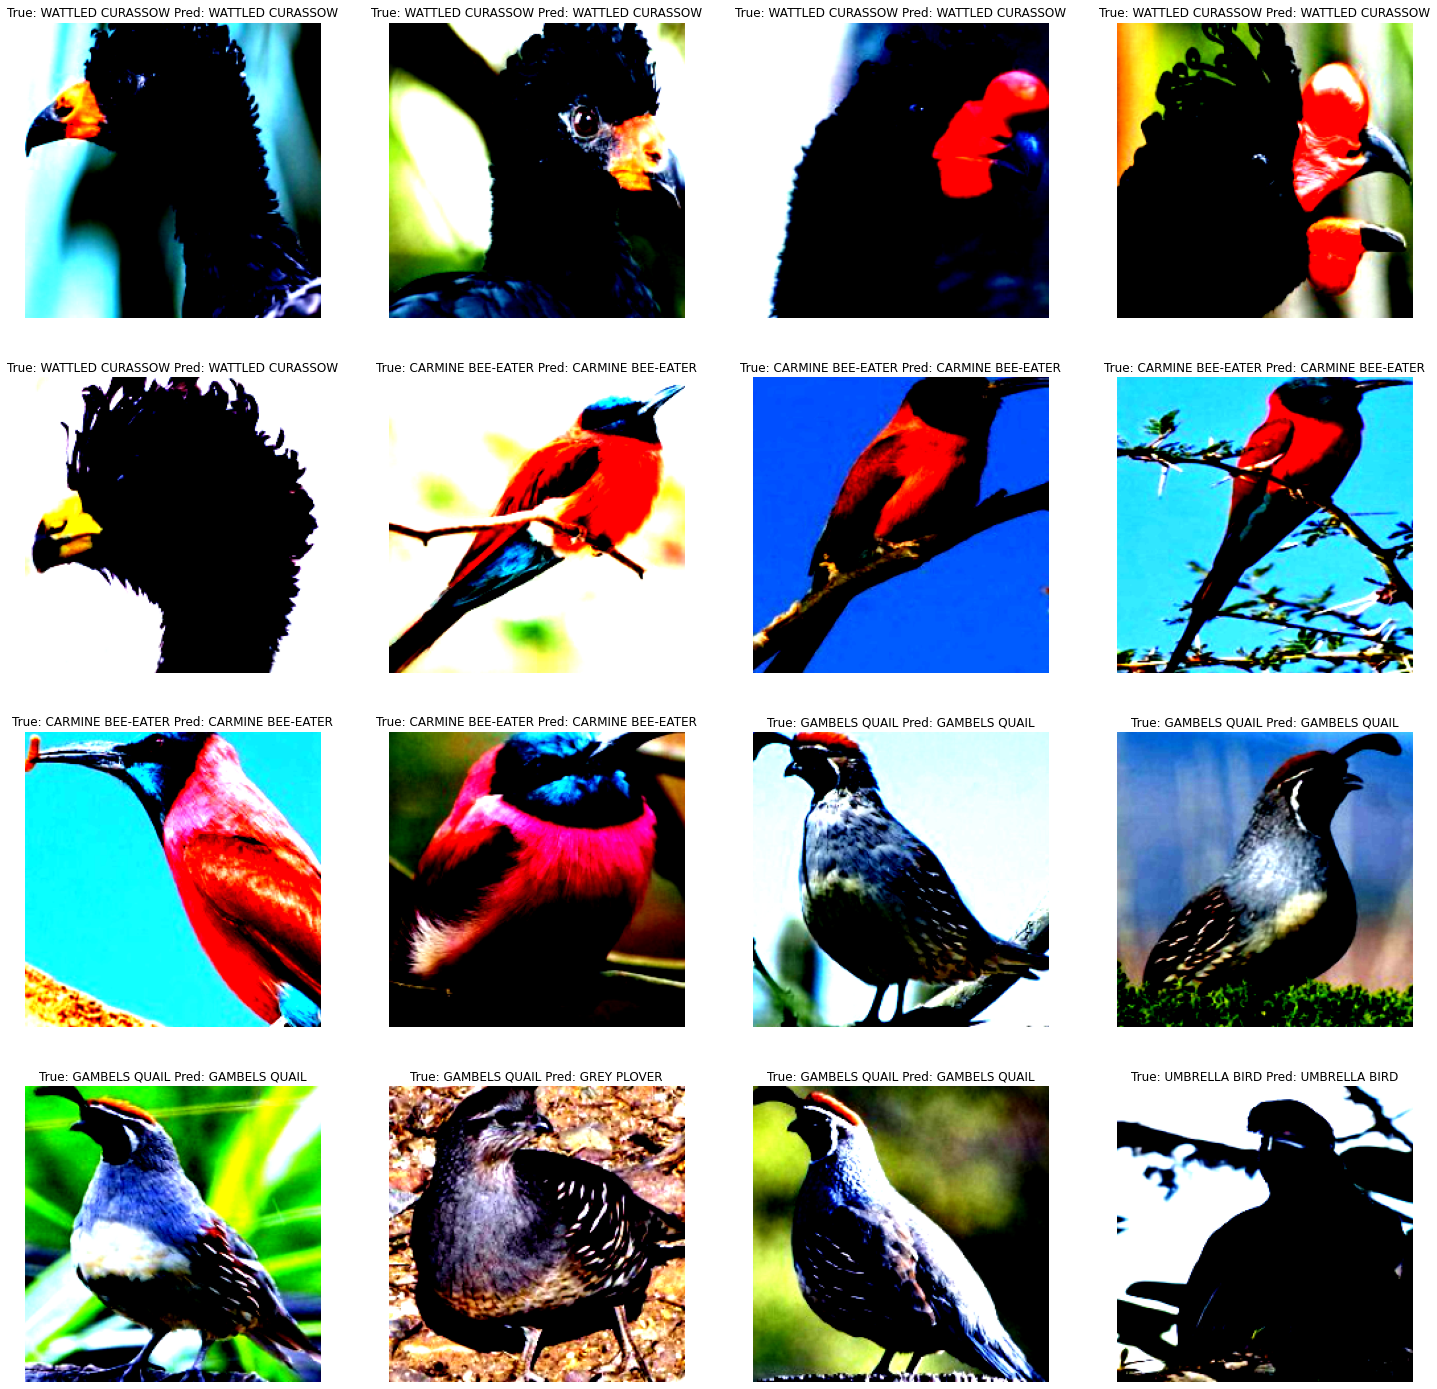

In [23]:
for images, labels in test_data_loader:
    images = images.to(device)
    labels = labels.to(device)
        
    #Forward ->
    preds = model(images)
        
    #Calculate Accuracy
    acc = calc_accuracy_2(labels.cpu(), preds.cpu())
        
    break
    

row=4
col=4
#(img,label) = next(iter(train_data_loader))
lbl = labels.cpu().numpy()
print(lbl)

pred_classes = np.argmax(preds.cpu().detach().numpy(), axis=1).flatten()
print(pred_classes)

      
images_cpu = images.cpu()
plt.figure(figsize=(25,int(25*row/col)))
for j in range(row*col):
    plt.subplot(row,col,j+1)
    plt.axis('off')
    plt.imshow(images_cpu[j].permute(1,2,0))
    #plt.imshow(images_cpu[j])
    plt.title("True: "+ int_to_class[int(lbl[j])] +" Pred: "+int_to_class[int(pred_classes[j])])
    

In [24]:
total_acc = []
for images, labels in test_data_loader:
    images = images.to(device)
    labels = labels.to(device)
        
    #Forward ->
    preds = model(images)
        
    #Calculate Accuracy
    acc = calc_accuracy_2(labels.cpu(), preds.cpu())
    total_acc.append(acc)    

mean_total_acc = np.mean(total_acc)
print(total_acc)
print("\nTest accuracy: {}".format(mean_total_acc))

[93.75, 87.5, 100.0, 81.25, 93.75, 100.0, 81.25, 93.75, 93.75, 87.5, 87.5, 100.0, 100.0, 100.0, 100.0, 100.0, 93.75, 87.5, 93.75, 93.75, 93.75, 93.75, 81.25, 75.0, 100.0, 100.0, 100.0, 93.75, 93.75, 100.0, 93.75, 100.0, 87.5, 100.0, 87.5, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 87.5, 100.0, 100.0, 100.0, 93.75, 93.75, 93.75, 100.0, 93.75, 100.0, 93.75, 100.0, 100.0, 93.75, 100.0, 100.0, 87.5, 100.0, 100.0, 87.5, 81.25, 87.5, 100.0, 100.0, 93.75, 100.0, 93.75, 93.75, 93.75, 93.75, 100.0, 87.5, 93.75, 93.75, 100.0, 87.5, 93.75, 100.0, 100.0, 93.75, 93.75, 100.0, 93.75, 100.0, 100.0, 100.0, 100.0, 75.0, 100.0, 93.75, 100.0, 100.0, 93.75, 81.25, 100.0, 87.5, 100.0, 87.5, 93.75, 93.75, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 93.75, 93.75, 100.0, 81.25, 100.0, 100.0, 81.25, 87.5, 81.25, 100.0, 81.25, 93.75, 100.0, 93.75, 93.75, 93.75, 81.25, 81.25]

Test accuracy: 94.5


# Sample Picture For MobilNet

In [25]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [26]:

# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

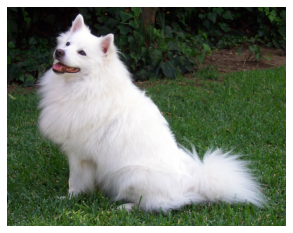

In [27]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)

plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(input_image)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [28]:
with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes

#print(output[0])

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

#print(probabilities)

In [29]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-06-24 11:26:04--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-06-24 11:26:05 (46.1 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [30]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

pole 0.012757512740790844
bucket 0.011861960403621197
hook 0.008899183012545109
paper towel 0.008813736028969288
bow tie 0.008295389823615551
